<a href="https://colab.research.google.com/github/NanoGS2/python-ciencia-datos/blob/main/Copia_de_Copia_de_TP_final_en_limpio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Vamos a necesitar muchas cosas para buscar los datos

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [ ]:
# Vamos a buscar los datos meteorológicos de la estación Mendoza Aero,
# estos contienen: viento (dirección e intensidad), temperatura, visibilida
# fenomenos significativos (lluvia, neblina), tipos y altura de nubosidad
# presión, etc. Con estos datos vamos a hacer promedios para comparar el
# año 2022 con los registros historicos y clasificarlo en
# año cálido, promedio o frío, lluvioso, seco o promedio en una primera
# instancia.
# Luego vamos a seleccionar parte del data frame por eventos y ver como se
# correlacionan las variables entre si para cada uno de ellos.
# Buscaremos los eventos Zonda, los eventos Frente frío y tormentas para ver
# si podemos detectar algún patron previo a éstos para ayudar a su detección
# lo antes posible.



###                                            -------------Apartado de funciones ------------------------

In [ ]:
#Función para extraer datos de una url con un formato específico

def extract_data(url):
  r = requests.get(url)
  html_contents = r.text
  html_soup = BeautifulSoup(html_contents, "html.parser")
  tabla_datos = html_soup.find_all("table", class_="border_brown")
  columnas_1 = ["Todos"]
  df = pd.DataFrame(columns= columnas_1)
  #De todas las cosas que saqué de la página, tomo lo que me sirve
  values = []
  for table in tabla_datos:
    for row in table.find_all("tr"):
      for col in row.find_all(["td"]):
        values.append(col.text)
      if len(values) == 1:
        df.loc[len(df)] = values
  arr_values = np.array(values[1:])
  arr_values = arr_values.reshape(int(len(arr_values)/4),4)
  col = ["Tipo de mensaje", "Fecha", "Borrar Columna", "Synop"]
  arr_values.shape
  df = pd.DataFrame(arr_values, columns = col)
  return df

In [ ]:
#Función para remover caracteres a una lista, la vamos a usar más adelante
#Se usa en extract data
def remove_char(lista,char):
  temp_list=[]
  for i in lista:
    s=i.translate(str.maketrans('', '', char))
    temp_list.append(s)
  return temp_list

In [ ]:
#transformamos un array en lista para poder usar la función anterior y remover carácteres
#Se usa en extract data
def arr_to_list(arr):
  list_ = []
  for i in arr:
    s="".join(i)
    list_.append(s)
  return list_

In [ ]:
#Funcion para separar un array en columnas, devuelve un array en forma de matriz
#Se usa en extract data
def sep_array_col(arr):
  lista_madre=[]
  for i in arr:
    s="".join(i)
    lista_madre.append(s)

  lista_con_columnas=[]
  for i in lista_madre:
    lista_con_columnas.append(i.split(" "))
  a = np.array(lista_con_columnas,dtype=object)
  a = a.reshape(len(a),1)
  return a

In [ ]:
#Función para formatear las columnas que se refieren al tiempo

def df_time_ajust(df):
  df["Fecha"] = pd.to_datetime(df["Fecha"],format="%d/%m/%Y")
  df["Fecha"] = df_split["Fecha"].dt.strftime("%d/%m/%Y")
  df["Hora"] = pd.to_datetime(df["Hora"],format="%H:%M:%S")
  df["Hora"] = df["Hora"].dt.time
  return df

In [ ]:
#Creo una lista con dos columnas separando fecha y hora separo de los datos en bruto la columna fecha y hora
#Uso una funcion previa para en un solo paso tambien limpiar la flecha "-->"
#datos es solo la columna que tiene los datos de fecha y hora

def split_fecha_y_hora(datos):
  fecha_y_hora = []

  for i in datos["Fecha"]:
    fecha_y_hora.append(i.split(" "))

  arr_f_y_h = np.array(fecha_y_hora)
  arr_fecha, arr_hora = np.split(arr_f_y_h, 2, axis=1)

  arr_hora_new = remove_char(arr_to_list(arr_hora),"-->")
  arr_hora_final = np.array(arr_hora_new).reshape(len(datos),1)

  return arr_fecha, arr_hora_final

In [ ]:
#Hay outlires muy claros en las series de temperatura y temperatura de rocio asi que los cambiamos asi


def reemplazar_outliers(serie):
    for i in range(1, len(serie) - 1):
      valor_actual = serie[i]
      valor_anterior = serie[i - 1]
      valor_siguiente = serie[i + 1]

      if abs(valor_actual - valor_anterior) > 20:  # Puedes ajustar este umbral según tus datos
          serie[i] = (valor_anterior + valor_siguiente) / 2

    return serie

In [ ]:
#inicializo con un array de listas y finalizo con un data frame

def arr_to_df(arr):
  #Inicializa una lista vacía para almacenar las filas del DataFrame
  data_rows = []

  #Itera a través de cada fila en el array
  for row in arr:
      #Convierte la fila en una lista
      row_list = list(row)
      #Agrega la fila a la lista de filas
      data_rows.append(row_list)

  #Encuentra la longitud máxima de cualquier fila
  max_length = max(len(row) for row in data_rows)

  #Rellena las filas con valores NaN para que todas tengan la misma longitud
  for row in data_rows:
      while len(row) < max_length:
          row.append(np.nan)

  #Crea el DataFrame
  df = pd.DataFrame(data_rows)
  df = df[0].str.split(' ', expand=True)
  return df

  #Devuelve df con la estructura deseada

In [ ]:
#Divido el dataframe n columnas

def split_df(df):
  df = df[0].str.split(' ', expand=True)
  return df

In [ ]:
#Agrego las columnas fecha y hora al principio del df
#aprovecho y le agrego nombres a las columnas mas importantes


def sum_fecha_y_hora_format(df,fecha,hora):
  df.insert(0,"Fecha",fecha)
  df.insert(1,"Hora",hora)
  df = df.rename(columns={0: "Estación",1: "Cabecera",2: "Nubosidad y Viento",3:"Temperatura",4:"Td", 5:"Presión de Pista",
6:"SLP",7:"Tendencia"})
  return df

In [ ]:
def fun_madre(url):
  df=extract_data(url)
  arr_datos = np.array(df)
  arr_tipo_de_mensaje, arr_fecha_y_hora, arr_axx, arr_synops = np.split(df,4, axis=1)
  arr_fecha, arr_hora_final = split_fecha_y_hora(df)
  list_synops = arr_to_list(arr_synops["Synop"])
  list_synops = remove_char(list_synops,"=")
  list_synops = remove_char(list_synops,"\n")
  arr_synops_clean = np.array(list_synops)
  df=pd.DataFrame(arr_synops_clean)
  df=df[0].str.split(' ', expand=True)
  df=sum_fecha_y_hora_format(df,arr_fecha,arr_hora_final)
  df = df.rename(columns={0: "Estación",1: "Cabecera",2: "Nubosidad y Viento",3:"Temperatura",4:"Td", 5:"Presión de Pista",
  6:"SLP",7:"Tendencia"})

  return df


In [ ]:
#Más adelante vamosa a hacer graficar series temporales, esta funcion "prepara"
#el eje x para que sea una linea de tiempo.

def x_temp(df):
  # Crea un DataFrame con las series de días y horas
  df = pd.DataFrame({'Dia': df["Fecha"], 'Hora': df["Hora"]})

  # Crea una nueva columna 'Fecha' que combine días y horas para formar fechas completas
  df['Fecha'] = pd.to_datetime(df['Dia'].astype(str) + ' ' + df['Hora'].astype(str), format='%d/%m/%Y %H:%M')

  # La columna 'Fecha' ahora contiene fechas completas
  return df["Fecha"]

In [ ]:
#Creamos un printer de tablas
#Damos como parámetro la serie "Temperatura" y nos imprime una tabla con la mínima
#máxima media, mediana y desviacion standar

def print_tabla (temp):

  col_df=["Máxima", "Mínima" , "Media", "Mediana", "Desviación Standard"]
  data_=np.array([max(temp), min(temp), round(temp.mean(),1), round(temp.median(),1), round(temp.std(),1)]).reshape(1,5)

  tabla_=pd.DataFrame(data_, columns = col_df)


  fig, ax = plt.subplots(figsize=(6,6))
  ax.axis('tight')
  ax.axis('off')
  ax.table(cellText=tabla_.values, colLabels=tabla_.columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(tabla_.columns))
  plt.title('Tabla de Datos')
  plt.show()

In [ ]:
#Vamos a hacer una funcion que plotee series temporales:
#Usamos la funcion x_temp() para definir rápidamente el eje x (tiempo)
#usamos funciones que vamos a definir más adelante para filtrar las temperaturas
#por cuestiones de errores y de codificación en general


def plotear(df):

  x=x_temp(df)

  y3=(df["Temperatura"].astype(float)-10000)/10
  y2=y3.apply(corregir_temperatura)
  t_clean=reemplazar_outliers(y2)






  plt.figure(figsize=(12, 8))

  plt.plot(x,t_clean)

  #La serie para el eje x no se lee bien, así que le pedimos que se salten 96 datos (4 días)
  plt.xticks(x[::96], rotation=45)
  # Etiquetas para los ejes x e y
  plt.xlabel('Fechas')
  plt.ylabel('Temperaturas (°C)')
  # Título del gráfico
  plt.title('Serie Temporal de Temperaturas')
  # Mostrar la cuadrícula
  plt.grid(True)
  # Mostrar el gráfico
  plt.axhline(y=max(t_clean), color='red', linestyle='--', label='Temperatura Máxima')
  plt.axhline(y=min(t_clean), color='blue', linestyle='--', label='Temperatura Mínima')
  plt.legend()
  plt.show()








In [ ]:
#Este es un plot muy común e interesante para series temporales de temperatura
#Graficamos en un solo plot las temperaturas mínima, media y máximas diarias


def plotear_temp(df):
  x=df["Fecha"]
  y1=df['Temperatura_Media_Diaria']
  y2=df['Temperatura_Minima_Diaria']
  y3=df['Temperatura_Maxima_Diaria']

  plt.figure(figsize=(10, 6))  # Tamaño del gráfico (ancho, alto)

  plt.plot(x, y1, label='Temperatura Media', marker='o', linestyle='-', color='green')
  plt.plot(x, y2, label='Temperatura Mínima', marker='s', linestyle='--', color='blue')
  plt.plot(x, y3, label='Temperatura Máxima', marker='^', linestyle='-.', color='red')

  # Agregar etiquetas y título
  plt.xlabel('Fecha')
  plt.ylabel('Temperaturas')
  plt.title('Serie temporal de temperaturas Máxima, Mínima y Media')

  # Mostrar una leyenda
  plt.legend()

  # Mostrar el gráfico
  plt.grid(True)
  plt.show()

In [ ]:
# Combina 'Fecha' y 'Hora' en una sola columna de tipo DateTime
#Tambien usamos otras funciones para preparar los datos

def temp_diarias(df):

  df['Fecha_Hora'] = pd.to_datetime(df['Fecha'].astype(str) + ' ' + df['Hora'].astype(str), format='%d/%m/%Y %H:%M')

  # Establece 'Fecha_Hora' como índice
  df.set_index('Fecha_Hora', inplace=True)


  #Filtramos los erroes y decodificamos

  temp=(df["Temperatura"].astype(float)-10000)/10
  temp2 = temp.apply(corregir_temperatura)
  t_clean = reemplazar_outliers(temp2)




  # Calcula el promedio diario de la temperatura
  promedio_diario_temperatura = round(t_clean.resample('D').mean(),1)
  # Calcula la temperatura mínima diaria
  temperatura_minima_diaria = round(t_clean.resample('D').min(),1)
  # Calcula la temperatura máxima diaria
  temperatura_maxima_diaria = round(t_clean.resample('D').max(),1)


  #Creo el df que voy a retornar

  df_resultado = pd.DataFrame({
    'Temperatura_Media_Diaria': promedio_diario_temperatura,
    'Temperatura_Minima_Diaria': temperatura_minima_diaria,
    'Temperatura_Maxima_Diaria': temperatura_maxima_diaria
  })
  # Agregar la columna 'Fecha' a la izquierda del DataFrame 'df_resultado'
  df_resultado.insert(0, 'Fecha', df_resultado.index)

  # Reiniciar el índice para convertir la columna 'Fecha' en una columna regular
  df_resultado.reset_index(drop=True, inplace=True)

  #Ya que estamos por acá hacemos una tabla con lo que acabamos de crear

  fig, ax = plt.subplots(figsize=(15,10))
  ax.axis('tight')
  ax.axis('off')
  ax.table(cellText=df_resultado.values, colLabels=df_resultado.columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(df_resultado.columns)).set_fontsize(500)
  plt.show()




  return df_resultado

In [ ]:
#Por la forma en que se codifican las temperaturas negativas, tengo que aplicar
#este filtro

def corregir_temperatura(temperatura):
    if temperatura > 100 and temperatura <500:
        return (100 - temperatura)
    else:
        return temperatura


In [ ]:
#Parecido a corregir_temperatura, esta funcion decodifica el viento, descomponiendo
#la columna en dos que contienen la direccion del viento y la intensidad por separado
#Retornamos dos columnas

def conver_viento(df):
  # Utiliza expresiones regulares para extraer la dirección y la intensidad
  df['Direccion'] = df['Nubosidad y Viento'].str.extract(r'(\d{2})\d{2}').fillna('00')
  df['Intensidad'] = df['Nubosidad y Viento'].str.extract(r'\d{2}(\d{2})').fillna('00')

  #Convierte las columnas en enteros
  df['Direccion'] = (df['Direccion'].astype(int))*10
  df['Intensidad'] = df['Intensidad'].astype(int)

  # Muestra el DataFrame resultante

  print(df["Direccion"],df["Intensidad"])

In [ ]:
#Copiamos el df para que la funcion retorne otro sin modificarlo,
#Combinamos las columnas fecha y hora
#Dividimos viento e intensidad y multiplicamos al viento *10 para que quede
#correctamente expresado en grados (0-360 donde 360 es el norte, 090 el este
#180 el sur y 270 el oeste)
#Retorna un nuevo DF


def procesar_df(df):
    # Copia el DataFrame original para no modificarlo directamente
    df_resultado = df.copy()

    # Combinar las columnas "Fecha" y "Hora" en una sola columna "Fecha y Hora"
    df_resultado['Fecha y Hora'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'])

    # Utiliza expresiones regulares para extraer la dirección y la intensidad del viento
    df_resultado['Direccion del Viento'] = (df['Nubosidad y Viento'].str.extract(r'\d(\d{2})\d').fillna('00').astype(int))*10
    df_resultado['Intensidad del Viento'] = df['Nubosidad y Viento'].str.extract(r'\d{3}(\d{2})').fillna('00')

    # Convierte las columnas "Direccion del Viento" e "Intensidad del Viento" en enteros
    df_resultado['Direccion del Viento'] = df_resultado['Direccion del Viento'].astype(int)
    df_resultado['Intensidad del Viento'] = df_resultado['Intensidad del Viento'].astype(int)

    # Selecciona las columnas necesarias en el DataFrame resultante
    #df_resultado = df_resultado[['Fecha y Hora', 'Direccion del Viento', 'Intensidad del Viento', 'Temperatura', 'Td']]

    return df_resultado


In [ ]:
#Esto esta dentro de otra función, pero posiblemente necesite usarlo aparte
#Decodificamos y limpiamos la columna "Temperatura"

def prep_temp(df):
  data_temp = ((df["Temperatura"].astype(float)-10000)/10)
  data_temp2 = data_temp.apply(corregir_temperatura)
  serie_temp = reemplazar_outliers(data_temp2)
  return serie_temp

In [ ]:
# Hermosa funcion que imprime datos estadisticos de la serie temporal que le demos,
# un df crudo, lo preparamos y luego continuamos para graficar los datos estadisticos
# de la variable "Temperatura"

def est_y_plt(df):

    serie_temporal = prep_temp(df)

    media = serie_temporal.mean()
    para_boxplot = serie_temporal.fillna(media)

    # Calcular las estadísticas
    temperatura_maxima = serie_temporal.max()
    temperatura_minima = serie_temporal.min()
    temperatura_media = serie_temporal.mean()
    temperatura_mediana = serie_temporal.median()
    primer_cuartil = serie_temporal.quantile(0.25)
    tercer_cuartil = serie_temporal.quantile(0.75)
    desviacion_estandar = serie_temporal.std()


    # Crear un DataFrame con las estadísticas
    estadisticas_df = pd.DataFrame({
        'Temp Máxima': [temperatura_maxima],
        'Temp Mínima': [temperatura_minima],
        'Temp Media': [temperatura_media],
        'Mediana': [temperatura_mediana],
        'Primer Cuartil': [primer_cuartil],
        'Tercer Cuartil': [tercer_cuartil],
        'Desviación Estándar': [desviacion_estandar]
    })


    # Crear un gráfico de caja (boxplot)
    plt.figure(figsize=(8, 6))
    plt.boxplot(para_boxplot, vert=True)
    plt.title('Boxplot Temperaturas')
    plt.xlabel('Temperatura')


    # Crear un gráfico de distribución de temperaturas
    plt.figure(figsize=(8, 6))
    plt.hist(serie_temporal, bins=20, edgecolor='k')
    plt.title('Distribución de Temperaturas')
    plt.xlabel('Temperatura')
    plt.ylabel('Frecuencia')


    # Mostrar los gráficos
    plt.show()
    temp_diarias(df)
    plotear(df)

    return estadisticas_df

In [ ]:
def zonda(df):
    # Filtrar eventos Zonda
    eventos_zonda = df[(df['Direccion del Viento'] >= 250) &
                       (df['Direccion del Viento'] <= 340) &
                       (df['Intensidad del Viento'] > 10)]

    # Obtener los índices de los eventos Zonda
    indices_eventos_zonda = eventos_zonda.index.tolist()

    return indices_eventos_zonda

In [ ]:
#Concatenar datos ya que no puedo obtener más de un mes a la vez

def concatenar_df(dataframes):
    # Asegurarse de que los índices estén ordenados
    dataframes = [df.sort_index() for df in dataframes]

    # Crear un DataFrame de destino vacío con las columnas de todos los DataFrames
    columnas_destino = set().union(*[df.columns for df in dataframes])
    df_destino = pd.DataFrame(columns=columnas_destino)

    # Concatenar los DataFrames y rellenar columnas vacías
    for df in dataframes:
        # Revisar si hay columnas faltantes en el DataFrame actual
        columnas_faltantes = columnas_destino - set(df.columns)
        if columnas_faltantes:
            # Rellenar columnas faltantes con NaN
            for columna in columnas_faltantes:
                df[columna] = None  # O puedes usar df[columna] = np.nan si prefieres NumPy NaN

        # Concatenar el DataFrame actual al DataFrame de destino
        df_destino = pd.concat([df_destino, df])

    return df_destino

In [ ]:
#Pa excel
def pa_excel(df,nombre):

  # Especifica el nombre del archivo Excel en el que deseas guardar el DataFrame
  df_ = nombre + ".xlsx"

  # Utiliza to_excel() para exportar el DataFrame a un archivo Excel
  df.to_excel(df_)  # El argumento 'index=False' evita que se incluyan los índices en el archivo

In [ ]:
def concat(dataframes):
    # Asegurarse de que los índices estén ordenados y rellenar columnas vacías
    columnas_destino = list(set().union(*[df.columns.tolist() for df in dataframes]))
    df_destino = pd.DataFrame(columns=columnas_destino)

    for df in dataframes:
        df = df.sort_index()
        columnas_faltantes = list(set(columnas_destino) - set(df.columns))
        if columnas_faltantes:
            for columna in columnas_faltantes:
                df[columna] = None  # O puedes usar df[columna] = np.nan si prefieres NumPy NaN
        df_destino = pd.concat([df_destino, df])

    return df_destino


In [ ]:
#La funcion zonda devuelve una lista de índices, uso esta funcion para dividirla
#en varias listas que contendran los eventos por separado, suponiendo que
# si pasan mas de 5 horas entre evento ya son dos distintos, este numero podria variar mas adelante
#para poder imprimir los eventos por separado

def separar_lista(lista_numerica):
    # Inicializa una lista para almacenar las sublistas resultantes
    sublistas = []
    # Inicializa una lista auxiliar para acumular elementos
    sublista_actual = []

    # Recorre la lista numérica
    for num in lista_numerica:
        # Si la sublista está vacía o la diferencia entre el número actual y el último número en la sublista es mayor que 5
        if not sublista_actual or num - sublista_actual[-1] > 5:
            # Inicia una nueva sublista
            sublista_actual = [num]
            # Agrega la nueva sublista a la lista de sublistas
            sublistas.append(sublista_actual)
        else:
            # Agrega el número actual a la sublista actual
            sublista_actual.append(num)

    return sublistas

In [ ]:
def torta(df, indices_tienes):

    # Obtener todos los índices disponibles en el DataFrame
    todos_los_indices = df.index.tolist()

    # Calcular los índices que no tienes
    indices_no_tienes = list(set(todos_los_indices) - set(indices_tienes))

    # Calcular las longitudes de ambas listas
    num_indices_tienes = len(indices_tienes)
    num_indices_no_tienes = len(indices_no_tienes)

    # Crear un gráfico de torta
    labels = ['Zonda', 'No Zonda']
    sizes = [num_indices_tienes, num_indices_no_tienes]
    colors = ['lightblue', 'lightcoral']
    explode = (0.1, 0)  # Separa la rebanada 'Tienes' del resto

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Para que el gráfico sea un círculo y no una elipse

    # Mostrar el gráfico
    plt.title('Proporción de horas Zonda vs Horas no Zonda')
    plt.show()

In [ ]:
def contador(df, indices):
    # Asegurarse de que el índice del DataFrame sea de tipo datetime
    df.index = pd.to_datetime(df.index)

    # Crear una serie booleana indicando si cada día tiene al menos un índice de la lista
    dias_con_indices = df.loc[indices].groupby(df.index.date).any()

    # Contar la cantidad de días con al menos un índice y el total de días
    num_dias_con_indices = dias_con_indices.sum()
    total_dias = len(dias_con_indices)

    return num_dias_con_indices, total_dias

In [ ]:
#Veamos el grafico de torta introduciendo el df PROCESADO

def index_unicos(df):

  index_zonda = zonda(df)
  zondas_ = df["Fecha"].loc[index_zonda]
  lista_unica = list(set(zondas_))
  fechas_zonda = lista_unica(zondas_)
  tercer_lista = [elemento for elemento in list(df["Fecha"]) if elemento not in lista_unica]
  return tercer_lista

In [ ]:
def zonda_torta(df,mes):

  valores_unicos = list(set(list(df["Fecha"].loc[zonda(df)])))

  a = list(set(list(df["Fecha"])))

  c = [elemento for elemento in a if elemento not in valores_unicos]

  d = len(valores_unicos)
  e = len(c)

  # Crear una lista con los valores
  valores = [d, e]

  # Etiquetas para las porciones de la torta
  etiquetas = ['Zonda', 'No Zonda']

  # Colores para cada porción
  colores = ['lightblue', 'lightcoral']

  # Separa la porción "Número 1" del resto
  explode = (0.1, 0)

  # Crea el gráfico de torta
  plt.figure(figsize=(6, 6))
  plt.pie(valores, labels=etiquetas, colors=colores, explode=explode,autopct="%.0f", shadow=True, startangle=140)
  plt.axis('equal')  # Para que el gráfico sea un círculo

  # Título del gráfico
  plt.title(f'Dias con Zonda vs dias sin Zonda para el mes de {mes}')

  # Muestra el gráfico
  plt.show()

### -----------------Hasta acá el apartado de funciones------------------
### -----------------      Importamos los datos        ------------------


Vamos a importar datos meteorológicos de la estación Mendoza Aero ubicada en el aeropuerto internacional Gabrielli para todos los meses del 2021 (año al azar)



In [ ]:
df_enero = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=01&day=01&hora=00&anof=2021&mesf=01&dayf=31&horaf=23&enviar=Ver")

In [ ]:
df_febrero = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=02&day=01&hora=00&anof=2021&mesf=02&dayf=28&horaf=23&enviar=Ver")

IndexError: ignored

In [ ]:
df_marzo = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=03&day=01&hora=00&anof=2021&mesf=03&dayf=31&horaf=23&enviar=Ver")

In [ ]:
df_abril = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=04&day=01&hora=00&anof=2021&mesf=04&dayf=30&horaf=23&enviar=Ver")

In [ ]:
df_mayo = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=05&day=01&hora=00&anof=2021&mesf=05&dayf=31&horaf=23&enviar=Ver")

In [ ]:
df_junio = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=06&day=01&hora=00&anof=2021&mesf=06&dayf=30&horaf=23&enviar=Ver")

In [ ]:
df_julio = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=07&day=01&hora=00&anof=2021&mesf=07&dayf=31&horaf=23&enviar=Ver")

In [ ]:
df_agosto = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=08&day=01&hora=00&anof=2021&mesf=08&dayf=31&horaf=23&enviar=Ver")

In [ ]:
df_septiembre = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=09&day=01&hora=00&anof=2021&mesf=09&dayf=30&horaf=23&enviar=Ver")

In [ ]:
df_octubre = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=10&day=01&hora=00&anof=2021&mesf=10&dayf=31&horaf=23&enviar=Ver")

In [ ]:
df_noviembre = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=11&day=01&hora=00&anof=2021&mesf=11&dayf=30&horaf=23&enviar=Ver")

In [ ]:
df_diciembre = fun_madre("https://www.ogimet.com/display_synops2.php?lugar=87418&tipo=ALL&ord=DIR&nil=SI&fmt=html&ano=2021&mes=12&day=01&hora=00&anof=2021&mesf=12&dayf=31&horaf=23&enviar=Ver")

In [ ]:
dataframes = [df_enero,
                        df_febrero,
                        df_marzo,
                        df_abril,
                        df_mayo,
                        df_junio,
                        df_julio,
                        df_agosto,
                        df_septiembre,
                        df_octubre,
                        df_noviembre,
                        df_diciembre]
df_2021 = concat(dataframes)
print(df_2021)

In [ ]:

pa_excel(df_enero,"Enero")
pa_excel(df_febrero,"Febrero")
pa_excel(df_marzo,"Marzo")
pa_excel(df_abril,"Abril")
pa_excel(df_mayo,"Mayo")
pa_excel(df_junio,"Junio")
pa_excel(df_julio,"Julio")
pa_excel(df_agosto,"Agosto")
pa_excel(df_septiembre,"Septiembre")
pa_excel(df_octubre,"Octubre")
pa_excel(df_noviembre,"Noviembre")
pa_excel(df_diciembre,"Diciembre")
pa_excel(df_2021,"2021")


In [ ]:
df_enero = pd.read_excel("/content/Enero.xlsx")
df_febrero = pd.read_excel("/content/Febrero.xlsx")
df_marzo = pd.read_excel("/content/Marzo.xlsx")
df_abril = pd.read_excel("/content/Abril.xlsx")
df_mayo = pd.read_excel("/content/Mayo.xlsx")
df_junio = pd.read_excel("/content/Junio.xlsx")
df_julio = pd.read_excel("/content/Julio.xlsx")
df_agosto = pd.read_excel("/content/Agosto.xlsx")
df_septiembre = pd.read_excel("/content/Septiembre.xlsx")
df_octubre = pd.read_excel("/content/Octubre.xlsx")
df_noviembre = pd.read_excel("/content/Noviembre.xlsx")
df_diciembre = pd.read_excel("/content/Diciembre.xlsx")

### -------------- Fin de la importación ----------------
### -------------- Analizamos los datos  ----------------

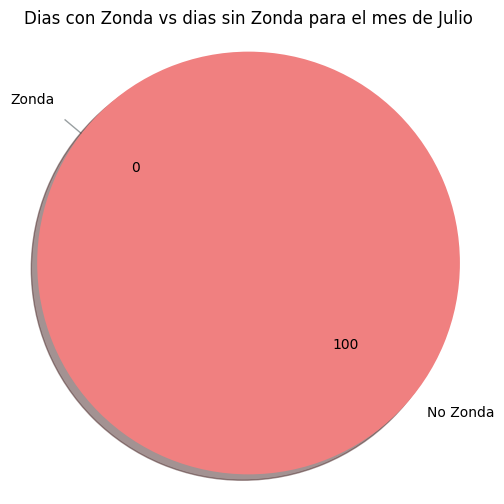

In [ ]:
zonda_torta(procesar_df(df_julio.astype(str)),"Julio")

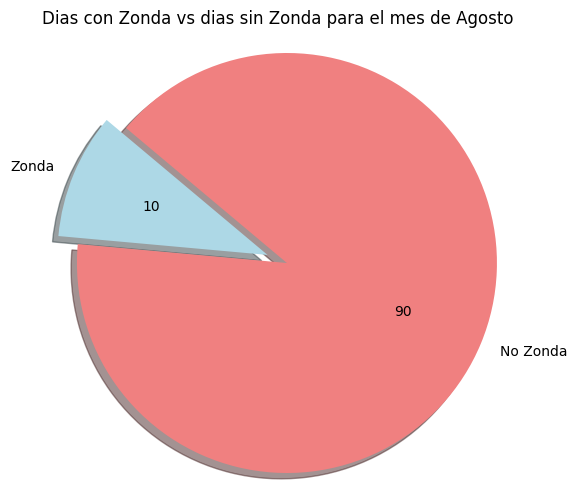

In [ ]:
zonda_torta(procesar_df(df_agosto.astype(str)),"Agosto")

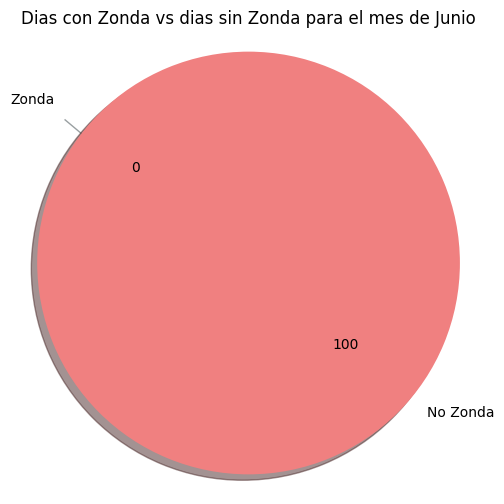

In [ ]:
zonda_torta(procesar_df(df_junio.astype(str)),"Junio")

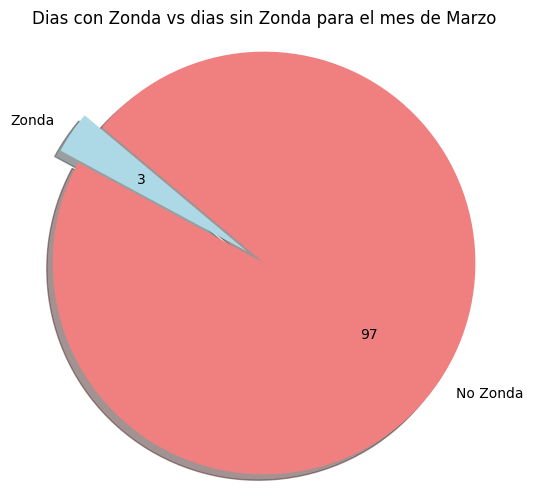

In [ ]:
zonda_torta(procesar_df(df_marzo.astype(str)),"Marzo")

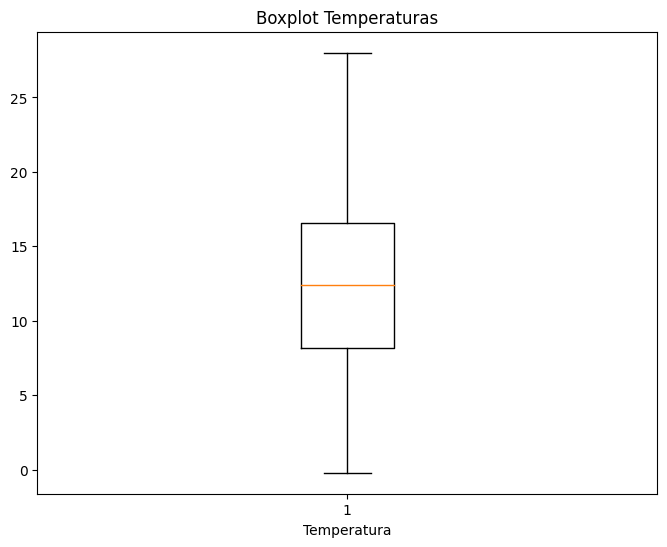

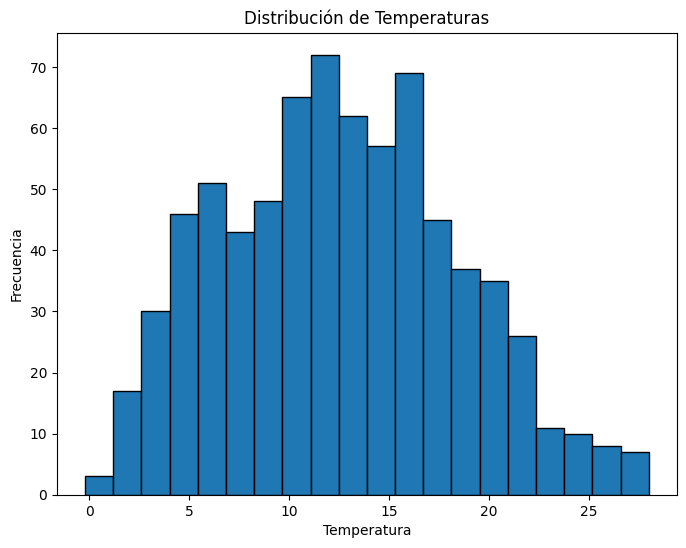

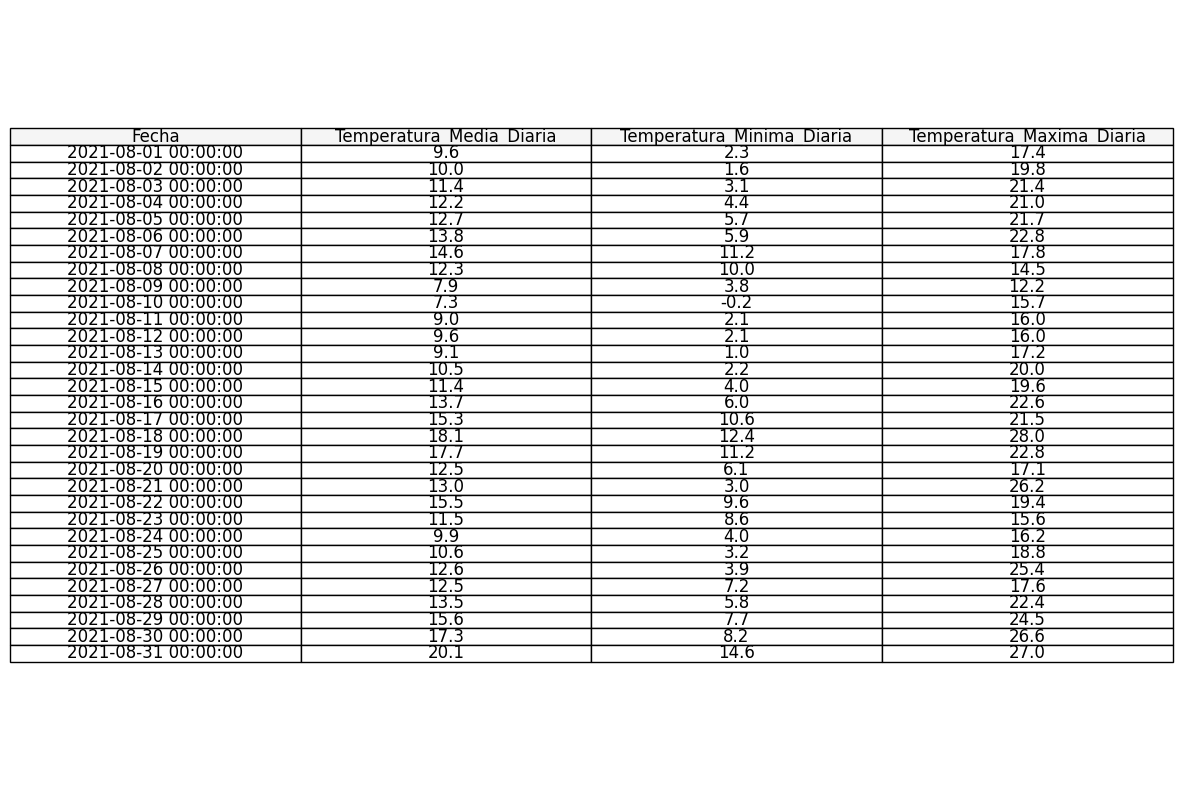

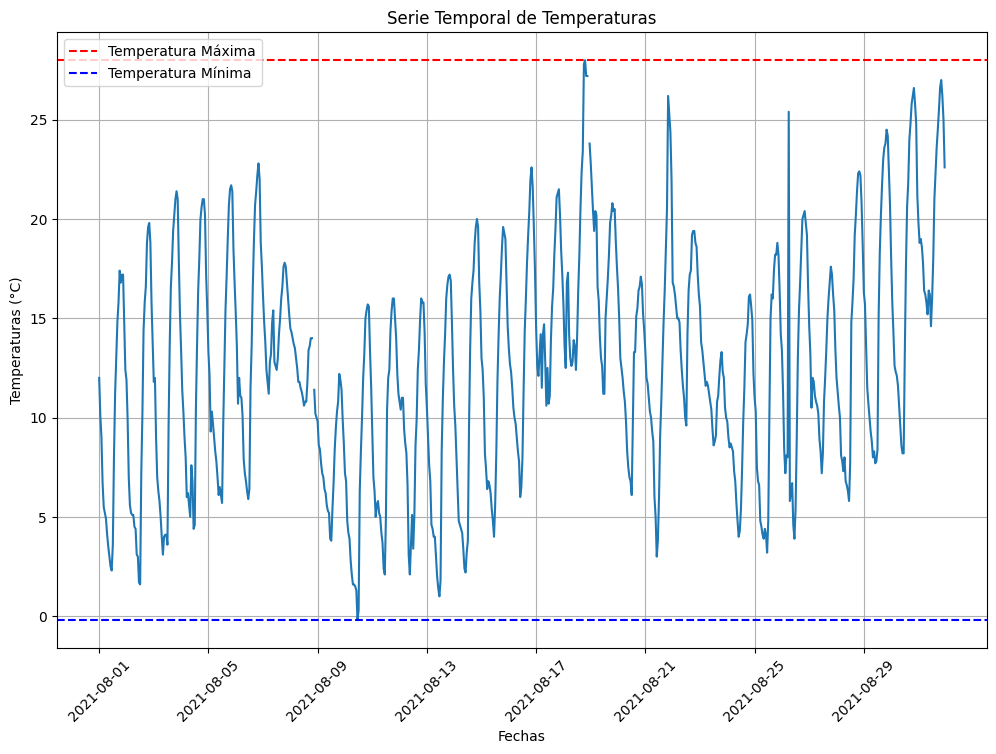

,Temp Máxima,Temp Mínima,Temp Media,Mediana,Primer Cuartil,Tercer Cuartil,Desviación Estándar
0,28.0,-0.2,12.59407,12.4,8.2,16.6,5.804321


In [ ]:
est_y_plt(procesar_df(df_agosto.astype(str)))